In [1]:
import time

import requests
from werkzeug import urls
import ray
from ray.experimental import serve
from ray.experimental.serve.utils import pformat_color_json
import json
from ray.experimental.serve.utils import BytesEncoder
from torchvision.models.resnet import resnet50
import io
from PIL import Image
from torch.autograd import Variable
import torchvision.transforms as transforms
import base64

class Transform:
	def __init__(self,transform):
		self.transform = transform
	def __call__(self,data):
		data = Image.open(io.BytesIO(base64.b64decode(data)))
		if data.mode != "RGB":
			data = data.convert("RGB")
		data = self.transform(data)
		data = data.unsqueeze(0)
		return data

class Resnet50:
	def __init__(self, model):
		self.model = model

	def __call__(self, data):
		# if 'transform' in context:
		# data = context['transform']
		data = Variable(data)
		data = data.cuda()
		return self.model(data).data.cpu().numpy().argmax()
		# return context['transform']
		# return ''



min_img_size = 224
transform = transforms.Compose([transforms.Resize(min_img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])])
model = resnet50(pretrained=True)
model = model.cuda()

serve.init(object_store_memory=int(1e9),blocking=True)
#create Backends
serve.create_backend(Transform, "transform:v1",0,transform)
serve.create_backend(Resnet50,"r50",1,model)

# create service
serve.create_no_http_service("transform")
serve.create_no_http_service("imagenet-classification")

#link service and backend
serve.link_service("transform", "transform:v1")
serve.link_service("imagenet-classification", "r50")

#Add service dependencies to pipeline
serve.add_service_dependencies("pipeline1","transform","imagenet-classification")

# Provision the PIPELINE (You can provision the pipeline only once)
serve.provision_pipeline("pipeline1")

# You can only create an endpoint for pipeline after provisioning the pipeline
serve.create_endpoint_pipeline("pipeline1", "/imgNetClassification", blocking=True)





time.sleep(2)

2019-10-11 16:10:03,206	WARNING worker.py:1426 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-10-11 16:10:03,212	INFO resource_spec.py:205 -- Starting Ray with 285.11 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-10-11 16:10:04,564	INFO global_state.py:55 -- [Global State] Initalizing routing table
2019-10-11 16:10:05,273	INFO global_state.py:59 -- [Global State] Health checking routing table 0
2019-10-11 16:10:05,274	INFO global_state.py:70 -- [Global State] Initializing queuing system
2019-10-11 16:10:05,281	INFO global_state.py:62 -- [Global State] Initializing HTTP server
2019-10-11 16:10:05,346	INFO global_state.py:88 -- [Global State] Checking if HTTP server is ready.5 retries left.


(pid=43767) INFO: Started server process [43767]
(pid=43767) INFO: Waiting for application startup.
(pid=43767) INFO: Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


2019-10-11 16:10:06,354	INFO global_state.py:88 -- [Global State] Checking if HTTP server is ready.4 retries left.
2019-10-11 16:10:07,357	INFO global_state.py:96 -- BOTH VALUES kv:1 kv_pipeline: 1
2019-10-11 16:10:07,467	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <class 'torch.nn.backends.thnn.THNNFunctionBackend'> by using pickle. This may be inefficient.
2019-10-11 16:10:07,476	WARNING worker.py:479 -- WARNING: Serializing the class <class 'torchvision.models.resnet.ResNet'> failed, falling back to cloudpickle.


In [4]:
from datetime import datetime
import os
rootDir = './bird_dataset/images'
num_queries = 0
latency_list = []

for dirName, subdirList, fileList in os.walk(rootDir):
    if dirName == rootDir:
            continue
    for fname in fileList:
        time.sleep(2)
        if fname.startswith('.'):
            continue
        file_path = os.path.join(dirName,fname)
        req_json = { "transform": base64.b64encode(open(file_path, "rb").read()) }
        sent_data = json.dumps(req_json, cls=BytesEncoder, indent=2).encode()
        start = datetime.now()
        resp = requests.post("http://127.0.0.1:8000/imgNetClassification",data = sent_data).json()
        end = datetime.now()
        latency = (end - start).total_seconds()
        latency_list.append(latency)
        num_queries += 1
#         pbar.update(1)
        print("-------------- {} ---------------------".format(num_queries))
        print(resp)
        if num_queries == 1500:
            break
        

-------------- 1 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55570) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55586) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 3 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55610) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 4 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55634) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 5 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55644) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 6 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55652) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 7 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55676) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 8 -----------------

-------------- 55 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56474) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 56 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56482) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 57 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 56522) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 58 ---------------------(pid=43767) INFO: ('127.0.0.1', 56538) - "POST /imgNetClassification HTTP/1.1" 200
{'result': 600}

-------------- 59 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56548) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 60 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 56558) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 61 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56574) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 62 ---------

-------------- 109 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 57384) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 110 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 57400) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 111 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57438) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 112 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57448) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 113 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57458) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 114 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 57468) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 115 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57506) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 116 -

-------------- 163 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 58318) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 164 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58334) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 165 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58358) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 166 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 58390) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 167 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58406) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 168 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58416) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 169 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58426) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 170 -

-------------- 217 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59306) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 218 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59316) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 219 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59332) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 220 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59342) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 221 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59380) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 222 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59390) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 223 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59400) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 224 -

-------------- 271 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60162) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 272 ---------------------
{'result': 731}
(pid=43767) INFO: ('127.0.0.1', 60186) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 273 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60196) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 274 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60204) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 275 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60214) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 276 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 60232) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 277 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60240) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 278 -

-------------- 325 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 32886) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 326 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 32902) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 327 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 32912) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 328 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 32936) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 329 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 32952) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 330 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 32962) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 331 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 32978) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 332 -

-------------- 379 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33778) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 380 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33804) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 381 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33820) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 382 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33830) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 383 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33838) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 384 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33848) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 385 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33866) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 386 -

-------------- 433 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34668) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 434 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34678) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 435 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 34688) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 436 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 34726) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 437 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34750) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 438 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34766) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 439 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34776) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 440 -

-------------- 487 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 35596) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 488 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35620) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 489 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35644) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 490 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 35654) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 491 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35700) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 492 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 35716) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 493 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35734) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 494 -

-------------- 541 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36468) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 542 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36500) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 543 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36538) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 544 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 36562) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 545 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 36580) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 546 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36590) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 547 ---------------------
{'result': 852}
(pid=43767) INFO: ('127.0.0.1', 36606) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 548 -

-------------- 595 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37436) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 596 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37446) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 597 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37480) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 598 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37504) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 599 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37520) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 600 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37532) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 601 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37540) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 602 -

-------------- 649 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 38390) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 650 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 38398) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 651 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 38408) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 652 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 38426) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 653 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 38442) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 654 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 38458) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 655 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 38482) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 656 -

-------------- 703 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39302) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 704 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 39310) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 705 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39320) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 706 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39330) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 707 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39346) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 708 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39356) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 709 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 39366) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 710 -

-------------- 757 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 40188) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 758 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 40198) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 759 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 40230) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 760 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 40240) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 761 ---------------------
{'result': 852}
(pid=43767) INFO: ('127.0.0.1', 40248) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 762 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 40266) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 763 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 40276) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 764 -

-------------- 811 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 41130) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 812 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 41148) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 813 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 41164) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 814 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 41174) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 815 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 41184) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 816 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 41200) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 817 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 41210) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 818 -

-------------- 865 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42040) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 866 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42048) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 867 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42058) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 868 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42068) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 869 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 42078) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 870 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42086) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 871 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 42096) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 872 -

-------------- 919 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 42964) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 920 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 42988) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 921 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43006) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 922 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43016) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 923 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43032) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 924 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43042) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 925 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43058) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 926 -

-------------- 973 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43860) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 974 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43870) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 975 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43880) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 976 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43904) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 977 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 43914) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 978 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43922) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 979 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 43946) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 980 -

-------------- 1027 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 44806) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1028 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 44816) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1029 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 44826) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1030 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 44834) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1031 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 44866) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1032 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 44876) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1033 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 44886) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1081 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45718) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1082 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45750) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1083 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45758) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1084 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45768) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1085 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45786) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1086 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 45794) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1087 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 45804) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1135 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 46640) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1136 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46648) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1137 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46658) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1138 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46668) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1139 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46678) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1140 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46686) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1141 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 46710) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1189 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 47550) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1190 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 47566) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1191 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 47584) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1192 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 47600) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1193 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 47624) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1194 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 47634) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1195 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 47650) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1243 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 48438) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1244 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 48454) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1245 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 48464) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1246 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 48472) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1247 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 48482) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1248 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 48506) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1249 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 48516) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1297 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49386) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1298 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49418) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1299 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49434) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1300 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49452) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1301 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49460) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1302 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 49470) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1303 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 49494) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1351 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50296) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1352 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50314) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1353 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50344) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1354 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50354) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1355 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50364) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1356 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 50374) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1357 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 50384) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1405 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 51166) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1406 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 51212) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1407 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 51224) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1408 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 51234) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1409 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 51244) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1410 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 51260) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1411 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 51284) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1459 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 52132) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1460 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 52142) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1461 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 52150) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1462 ---------------------
{'result': 731}
(pid=43767) INFO: ('127.0.0.1', 52174) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1463 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 52192) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1464 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 52216) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1465 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 52226) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1513 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 53020) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1514 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 53088) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1515 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 53112) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1516 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 53144) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1517 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 53160) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1518 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 53170) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1519 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 53180) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1567 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 53952) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1568 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 53982) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1569 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54014) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1570 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54032) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1571 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54040) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1572 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54064) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1573 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54074) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1621 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54934) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1622 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54950) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1623 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54960) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1624 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54970) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1625 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54980) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1626 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 54988) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1627 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 54998) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1675 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55758) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1676 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55768) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1677 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55776) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1678 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 55808) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1679 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55818) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1680 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55828) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1681 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 55880) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1729 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56650) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1730 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 56696) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1731 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56734) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1732 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56744) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1733 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 56754) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1734 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56762) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1735 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 56786) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1783 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57642) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1784 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57650) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1785 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57682) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1786 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 57692) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1787 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57702) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1788 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 57710) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1789 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 57728) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1837 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58524) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1838 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 58534) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1839 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58542) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1840 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 58552) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1841 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58562) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1842 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 58594) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1843 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 58604) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1891 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59448) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1892 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59458) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1893 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59482) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1894 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59494) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1895 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 59544) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1896 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59552) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1897 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 59570) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1945 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60378) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1946 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60388) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1947 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60398) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1948 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60414) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1949 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60438) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1950 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 60448) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 1951 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 60464) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 1999 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33040) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2000 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33050) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2001 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33066) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2002 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33090) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2003 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33108) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2004 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33116) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2005 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33126) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 2053 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33954) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2054 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 33970) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2055 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 33988) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2056 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34004) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2057 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34028) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2058 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34038) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2059 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34062) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 2107 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 34864) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2108 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34874) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2109 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34892) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2110 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 34922) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2111 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34932) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2112 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 34942) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2113 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 34958) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 2161 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35790) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2162 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35814) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2163 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 35830) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2164 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35854) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2165 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35864) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2166 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 35874) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2167 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 35890) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 2215 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 36668) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2216 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36676) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2217 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 36694) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2218 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36710) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2219 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 36720) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2220 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36758) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2221 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 36774) - "POST /imgNetClassification HTTP/1.1" 200
-------------

-------------- 2269 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37596) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2270 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37612) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2271 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37622) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2272 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37630) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2273 ---------------------
{'result': 600}
(pid=43767) INFO: ('127.0.0.1', 37648) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2274 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37658) - "POST /imgNetClassification HTTP/1.1" 200
-------------- 2275 ---------------------
{'result': 463}
(pid=43767) INFO: ('127.0.0.1', 37674) - "POST /imgNetClassification HTTP/1.1" 200
-------------

KeyboardInterrupt: 

/nethome/akhare39/anaconda3/envs/dl-py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


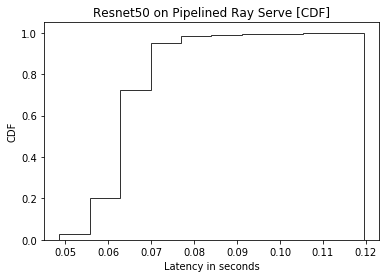

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import mlab
plt.figure()
# final = [1000*x for x in latency_list]
plt.hist(latency_list, normed=True, cumulative=True, label='CDF Distribution',
         histtype='step', alpha=0.8, color='k')
plt.ylabel('CDF')
plt.xlabel('Latency in seconds')
plt.title('Resnet50 on Pipelined Ray Serve [CDF]')
plt.show()
